# Setup

In [ ]:
# Mount the drive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
!pip install -q pyspark==3.5.5 spark-nlp==5.5.3
!pip install skl2onnx
!pip install onnxruntime-gpu
!pip install tldextract
!pip3 install newspaper3k
!pip install --upgrade lxml_html_clean

# Can also use the script below but the pyspark version is incompatible.
# !wget http://setup.johnsnowlabs.com/colab.sh -O - | bash

In [ ]:
import sparknlp

spark = sparknlp.start(gpu=True)

print("Spark NLP version", sparknlp.version())
print("Apache Spark version:", spark.version)

spark

Spark NLP version 5.5.3
Apache Spark version: 3.5.5


In [ ]:
from sparknlp.pretrained import PretrainedPipeline
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, udf
from pyspark.sql.types import ArrayType, StringType
import ast
from sparknlp.annotator import StopWordsCleaner
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sparknlp.annotator import StopWordsCleaner
from pyspark.ml import Pipeline
from sparknlp.base import LightPipeline
import os
import pandas as pd
import json
import joblib
from sklearn.preprocessing import StandardScaler
from scipy.sparse import hstack
from scipy.sparse import csr_matrix
import numpy
import newspaper
from newspaper import Article, Config

In [ ]:
sample_text = """
Most taxpayers will get a check from the $2tn economic package, the largest in US history

US coronavirus stimulus checks: are you eligible and how much will you get?

The US has agreed on a $2tn stimulus package, the largest economic stimulus in US history, in response to the economic impacts of Covid-19. While corporations will be the biggest recipients of the bailout, some of that money will be paid directly to Americans hit by the pandemic.

Most taxpayers will get a check in the mail, while those directly affected by the economic effects of Covid-19 are slated to receive robust government support.

Here’s what we know so far about how the new stimulus package will directly affect Americans in the coming weeks:

Who’s eligible for a check from the government?

Congress will spend about $250bn for checks up to $1,200 per person that will go directly to taxpayers.

To be eligible for the full amount, a person’s most recently filed tax return must show that they made $75,000 or under. For couples, who can receive a maximum of $2,400, the cutoff is $150,000.

If a person makes more than $75,000, the amount given goes down incrementally by $5 for every $100 increase in salary. So a person who makes $85,000 would get $700 while a person who makes $95,000 would get $200.

If a person makes above $99,000, or a couple makes above $198,000, no check will be given.

There are some requirements and exceptions. Those getting a check must be living and working in the US and have a valid social security number. If a person is listed as a dependent on their parents’ tax return – the case for many college students – they are excluded.

The Tax Foundation, a DC-based thinktank, estimates that 93.6% of Americans will be eligible for a check coming from the stimulus package.

What about parents?

Taxpayers will be given $500 per child 16 or under listed as a dependent on their latest tax return.

When will I get this money?

That is still unclear. Experts say that Americans will probably not get the money until May, given how long it takes the Internal Revenue Service (IRS) to send out checks. The treasury secretary, Steven Mnuchin, said those whose bank account information is already with the IRS from previous tax returns can expect a payment “within three weeks”.

For those who still need to give the IRS their bank account information, a web-based portal will be opening soon to allow people to provide the IRS with their information. The IRS says this is to make sure people get their checks immediately, instead of sending them through the mail.

This is not the first time the government has sent checks to Americans. The federal government gave up to $300 in 2001 and $600 in 2008 to taxpayers who met a certain income bracket to similarly stimulate the economy.

What if a person did not file their 2018 or 2019 return?

The IRS recommends people file their 2018 or 2019 tax return as soon as possible to get the payment. A check will be sent to any qualified person so long as they file their return within 2020.

What if a person does not file their taxes?

A person may still be eligible even if they do not file the taxes. The IRS says people who typically do not file taxes – low-income taxpayers and some veterans – will need to file a “simple tax return” in order to get the payment. Social security beneficiaries will not need to fill out the tax return, even if they do not file their taxes, to get the payment.

Does the package help unemployed workers?

Yes, specifically the bill will increase unemployment insurance by $600 for 13 weeks – about four months – for every person, added to the existing unemployment compensation a person gets from their state’s program.

The length and amount of compensation varies from state to state. A majority of states providing a maximum of 26 weeks of compensation, while average weekly compensation ranges from 20% of a person’s wage to just over 50%.

What about freelance and gig workers?

While unemployment insurance typically does not cover people who are self-employed – freelancers, contractors and gig workers – the bill comes with a “pandemic unemployment assistance” measure that will extend insurance to those workers.

Play Video 2:25 'The universe is collapsing': Bernie Sanders mocks Republicans over coronavirus aid – video

Have there been any changes to paid leave?

Not in this bill. Earlier last week, Donald Trump signed the Families First Coronavirus Response Act, a bill worth about $100bn meant to expand paid sick leave and emergency paid leave, but it came with major loopholes. Companies with over 500 employees were not mentioned in the bill, while companies with under 50 employees can apply for exemptions.

The bill mandates 10 days of fully paid sick leave for employees of companies with 500 employees or less. Parents of those companies affected by their children’s school closing and those leaving for medical reasons can get 12 weeks of pay at 67% of their salary.

Will there be anything to offset healthcare costs related to Covid-19?

Again, not in this bill. The Families First Coronavirus Response Act included a measure that mandated all Covid-19 testing is free, but treatment for any symptoms (there is currently no cure for the illness) still comes at a cost.

A few states have reopened enrollment for their health insurance programs to allow those concerned about costs to enroll, and three major health insurance companies said they will be waiving any high costs for treatment, but there are still stories of people getting bills for as much as $34,000 to cover treatment of the virus’s symptoms.
"""

In [ ]:
def init_clean_text_pipeline(text):
  nlp_pipeline = PretrainedPipeline("explain_document_ml", lang="en")
  stopwords_cleaner = StopWordsCleaner().pretrained('stopwords_iso', 'en') \
    .setInputCols(["token"]) \
    .setOutputCol("cleanTokens")
  default_stages = nlp_pipeline.model.stages
  custom_pipeline = Pipeline(stages=default_stages + [stopwords_cleaner])
  pipeline_model = custom_pipeline.fit(spark.createDataFrame([[text]]).toDF("text"))
  light_model = LightPipeline(pipeline_model, parse_embeddings=True)
  return light_model


clean_text_pipeline = init_clean_text_pipeline(sample_text)

explain_document_ml download started this may take some time.
Approx size to download 9 MB
[OK!]
stopwords_iso download started this may take some time.
Approximate size to download 2.1 KB
[OK!]


In [ ]:
# Define a function that takes an original text and returns a cleaned version
def clean_text(text, light_model=clean_text_pipeline, remove_stop_words=False, fix_spelling=False, join=True, delimiter=" "):
  result = light_model.annotate(text)
  output_col = 'cleanTokens' if remove_stop_words else ('spell' if fix_spelling else 'token')
  return delimiter.join(result[output_col]) if join else result[output_col]

In [ ]:
# Example 1: returning original with space characters as delimiter
text = clean_text("Hello, my name is Kittnipatt. I am studying Capstone. This is a very fun project! Thre is some spellling errors!")
assert(text == 'Hello , my name is Kittnipatt . I am studying Capstone . This is a very fun project ! Thre is some spellling errors !')

# Example 2: returning text with space characters as delimiter but also fix spelling
text = clean_text("Hello, my name is Kittnipatt. I am studying Capstone. This is a very fun project! Thre is some spellling errors!", fix_spelling=True)
assert(text == 'Hello , my name is Kittnipatt . I am studying Capstone . This is a very fun project ! There is some spelling errors !')

# Example 3: returning a list instead
text_list = clean_text("Hello, my name is Kittnipatt. I am studying Capstone. This is a very fun project!", join=False)
assert(text_list == ['Hello',
 ',',
 'my',
 'name',
 'is',
 'Kittnipatt',
 '.',
 'I',
 'am',
 'studying',
 'Capstone',
 '.',
 'This',
 'is',
 'a',
 'very',
 'fun',
 'project',
 '!'])

# Example 4: remove all stopwords
text = clean_text("Hello, my name is Kittnipatt. I am studying Capstone. This is a very fun project!", remove_stop_words=True)
assert(text == 'Hello , Kittnipatt . studying Capstone . fun project !')

# Example 5: using comma as a delimiter
text = clean_text("Hello, my name is Kittnipatt. I am studying Capstone. This is a very fun project!", delimiter=",")
assert(text == 'Hello,,,my,name,is,Kittnipatt,.,I,am,studying,Capstone,.,This,is,a,very,fun,project,!')

In [ ]:
# Load the source_bias_score.csv to Pandas
# TODO: Change this path to source_bias_score.csv
path = F"/content/gdrive/MyDrive/Capstone Project 2025/source_bias_score.csv"
source_bias_score_df = pd.read_csv(path)
source_bias_score_df.drop(columns=['Unnamed: 0'], inplace=True)
source_bias_score_df.head()

,domain,source,count,source_encoded,source_bias_score
0,aljazeera,Al Jazeera,104,4.0,0.5
1,allsides,National Review,3,108.0,1.5
2,apnews,Associated Press,235,14.0,0.0
3,axios,Axios,62,15.0,0.5
4,bbc,BBC News,603,16.0,1.0


In [ ]:
from tldextract import extract
import numpy as np


# Define a function that extracts the domain from the URL, then returns the corresponding 'source', 'source_encoded', and 'source_bias_score'
def convert_url_to_source(url):
  ext = extract(url)
  # Return the row in source_bias_score_df where domain equals ext.domain
  return source_bias_score_df[source_bias_score_df['domain'] == ext.domain]


assert(0.5 == convert_url_to_source('www.cnn.com')['source_bias_score'].values[0])

In [ ]:
# Load the test_pd_df_final.csv
path = F"/content/gdrive/MyDrive/Capstone Project 2025/test_pd_df_final.csv"
test_pd_df_final = pd.read_csv(path)
test_pd_df_final.head()

,topic,source,bias,url,title,date,authors,content,content_original,source_url,bias_text,ID,source_encoded,source_bias,predicted_bias
0,palestine,Breitbart News,2,http://www.breitbart.com/big-journalism/2015/0...,"Obama, Media Lied About Netanyahu and the Pale...",2015-03-20,Ben Shapiro,"For the last several days , the entire Western...","For the last several days, the entire Western ...",www.breitbart.com,right,uI2K5BSCO0LaWuKb,21,2.0,2
1,federal_budget,ABC News,0,http://abcnews.go.com/blogs/politics/2013/03/w...,Will Fractured House Republicans Unite on Budget?,NaN,John Parkinson,"Tomorrow morning , House Budget Chairman Paul ...","Jacquelyn Martin/AP Photo\n\nTomorrow morning,...",www.abcnews.go.com,left,zeSfcxLilzR0R1Dt,0,0.5,0
2,fbi,Reuters,1,https://www.reuters.com/article/us-usa-trump-r...,Trump blocks release of Russia memo drafted by...,2018-02-10,Ayesha Rascoe,WASHINGTON ( ███ ) - President Donald Trump on...,WASHINGTON (Reuters) - President Donald Trump ...,www.reuters.com,center,ru8kAxfdPzZc11le,132,1.0,1
3,politics,CBN,2,http://www1.cbn.com/cbnnews/politics/2019/febr...,Trump's North Korea Peace Talks Share Spotligh...,2019-02-25,NaN,"President Donald Trump arrives in Hanoi , Viet...","President Donald Trump arrives in Hanoi, Vietn...",www1.cbn.com,right,TTt5FFmsW6ng3fsC,26,2.0,2
4,media_bias,Breitbart News,2,http://www.breitbart.com/big-government/2017/0...,Six Times President Trump Upset Jared Kushner ...,2017-08-20,Adam Shaw,President Trump ’ s fiery response to the even...,President Trump’s fiery response to the events...,www.breitbart.com,right,gYKaZGjLCYdEghTZ,21,2.0,2


In [ ]:
# Load the TF-IDF Vectorizer
path = F"/content/gdrive/MyDrive/Capstone Project 2025/Models/tfidf_vectorizer.pkl"
tfidf_vectorizer = joblib.load(path)
tfidf_vectorizer

TfidfVectorizer(max_df=0.8, max_features=50000, min_df=10, ngram_range=(1, 2),
                stop_words='english', sublinear_tf=True)

In [ ]:
# Load the MinMaxScaler
path = F"/content/gdrive/MyDrive/Capstone Project 2025/Models/normalizer.pkl"
normalizer = joblib.load(path)
normalizer

Normalizer()

In [ ]:
# Load the Normalizer (Scaler)
path = F"/content/gdrive/MyDrive/Capstone Project 2025/Models/scaler.pkl"
scaler = joblib.load(path)
scaler

MinMaxScaler()

In [ ]:
# Load the Logistic Regression Model (With Extra Features)
path = F"/content/gdrive/MyDrive/Capstone Project 2025/Models/logreg.pkl"
logreg = joblib.load(path)
logreg

LogisticRegression(C=3.0, max_iter=1000, solver='saga')

In [ ]:
# Load the SGD Classifier
path = F"/content/gdrive/MyDrive/Capstone Project 2025/Models/sgd.pkl"
sgd = joblib.load(path)
sgd.get_params()

{'alpha': 0.0001,
 'average': False,
 'class_weight': None,
 'early_stopping': False,
 'epsilon': 0.1,
 'eta0': 0.0,
 'fit_intercept': True,
 'l1_ratio': 0.15,
 'learning_rate': 'optimal',
 'loss': 'log_loss',
 'max_iter': 1000,
 'n_iter_no_change': 5,
 'n_jobs': None,
 'penalty': 'l2',
 'power_t': 0.5,
 'random_state': 42,
 'shuffle': True,
 'tol': 0.001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [ ]:
from scipy.sparse import hstack


# Define a function that preprocesses all the columns to be predicted
def preprocess_test_columns_logreg(df=test_pd_df_final, vectorizer=tfidf_vectorizer, normalizer=normalizer):
  X = df["content"]
  y = df["bias"]
  X_test_vec = vectorizer.transform(df['content'])
  X_test_extra = df[["source_encoded", "source_bias"]]
  X_test_extra = normalizer.transform(X_test_extra)
  X_test_final = hstack((X_test_vec, X_test_extra))
  return (X_test_final, y)

In [ ]:
from scipy.sparse import hstack


# Define a function that preprocesses all the columns to be predicted
def preprocess_test_columns_sgd(df=test_pd_df_final, vectorizer=tfidf_vectorizer, scaler=scaler):
  X = df["content"]
  y = df["bias"]
  X_test_vec = vectorizer.transform(df['content'])
  X_test_vec = X_test_vec.astype("float32")
  X_test_extra = df[["source_encoded", "source_bias"]]
  X_test_extra = scaler.transform(X_test_extra)
  X_test_combined = hstack([X_test_vec, X_test_extra])
  return (X_test_combined, y)

In [ ]:
# Define a function that prints out accuracy report
def print_accuracy_report(y_test, y_pred):
  accuracy = accuracy_score(y_test, y_pred)
  report = classification_report(y_test, y_pred)

  print("Accuracy: {:.3f}\n".format(accuracy))
  print(report)

In [ ]:
# Test prediction with logreg
X_test, y_test = preprocess_test_columns_logreg()
y_pred = logreg.predict(X_test)
print_accuracy_report(y_test, y_pred)

Accuracy: 0.814

              precision    recall  f1-score   support

           0       0.80      0.82      0.81       402
           1       0.75      0.82      0.78       298
           2       0.86      0.81      0.83       599

    accuracy                           0.81      1299
   macro avg       0.80      0.82      0.81      1299
weighted avg       0.82      0.81      0.82      1299



In [ ]:
# Test prediction with sgd
X_test, y_test = preprocess_test_columns_sgd()
y_pred = sgd.predict(X_test)
print_accuracy_report(y_test, y_pred)

Accuracy: 0.904

              precision    recall  f1-score   support

           0       0.81      0.98      0.88       402
           1       0.88      0.67      0.76       298
           2       0.99      0.97      0.98       599

    accuracy                           0.90      1299
   macro avg       0.89      0.87      0.88      1299
weighted avg       0.91      0.90      0.90      1299



In [ ]:
from scipy.sparse import hstack


# Define a function that preprocesses all the columns to be predicted
def preprocess_test_columns_rf(df=test_pd_df_final, vectorizer=tfidf_vectorizer, normalizer= normalizer):
  X = df["content"]
  y = df["bias"]
  # Check the shape of the vectorized output
  X_test_vec = vectorizer.transform(df['content'])
  print("Shape of X_test_vec:", X_test_vec.shape)  # Add this line to check the shape

  X_test_extra = df[["source_encoded", "source_bias"]]
  X_test_extra = normalizer.transform(X_test_extra)
  X_test_final = hstack((X_test_vec, X_test_extra))

  print("Shape of X_test_final:", X_test_final.shape)  # Add this line to check the shape
  return (X_test_final, y)

# Full Pipeline

In [ ]:
url = 'https://www.nytimes.com/2024/05/08/us/politics/abortion-bans-latina-democrats.html'

In [ ]:
# Load the full text from the article
config = Config()
config.browser_user_agent = "Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:108.0) Gecko/20100101 Firefox/108.0"
article = Article(url, config=config)
article.download()

try:
  article.parse()
  text = article.text
except:
  print("Error parsing article! Please copy and paste the article's text below")
  text = """
Democrats, Sensing Shift on Abortion Rights Among Latinas, Push for More Gains
Hispanic views on the issue vary widely, and Democrats face hurdles, but opportunities, too. As one House candidate said: “I go to Mass, but I also support a woman’s right to choose.”

By Jazmine Ulloa
Jazmine Ulloa reported from Phoenix and interviewed about two dozen voters, organizers and elected officials and candidates on different sides of the abortion debate.

May 8, 2024
Hours before Arizona state legislators voted to repeal an 1864 abortion ban last month, a group of mostly Latina Democrats huddled at a nearby Mexican restaurant for a strategy session on galvanizing Latina voters over abortion rights.

“I am 23 — why do I have less rights than my abuelita in Mexico?” Melissa Herrera, a Democratic campaign staffer, asked the cluster of women at the restaurant, referring to her grandmother.

The question crystallized what Democrats hope will be a decisive electoral factor in their favor this year, one that upends conventional political wisdom: A majority of Latino voters now support abortion rights, according to polls, a reversal from two decades ago. Polling trends, interviews with strategists and election results in Ohio and Virginia, where abortion rights played a central role, suggest Democrats’ optimism regarding Latinas — once considered too religious or too socially conservative to support abortion rights — could bear out.

Since the Supreme Court struck down Roe v. Wade in 2022, stringent curbs have been taking effect in Republican-dominated states. In Arizona, for one, the May 2 repeal of the blanket ban from 1864 still leaves abortions governed by a two-year-old law prohibiting the procedure after 15 weeks of pregnancy, with no exception for rape or incest.

As of April 2023, according to the Pew Research Center, 62 percent of Latinos believed abortion should be legal in all or most cases. Twenty years earlier, most Hispanics told Pew that they opposed abortion rights by a nearly two-to-one margin. (The most recent polling has been conducted online, instead of over the phone, but the surveys show an overall gradual shift in opinions.)


Latino majorities came out in favor of reproductive rights in 2023 elections in Ohio and Virginia, according to other surveys, and women played a major role in stalling the shift of Hispanic voters toward the Republican Party in 2022, when many voted for Democrats, citing abortion and reproductive health as the most important issue.

“Abortion is going to be an essential issue this cycle,” said Victoria McGroary, the executive director of BOLD PAC, the campaign arm of the Congressional Hispanic Caucus. “We are going to see what I think is going to be crystal-clear evidence that reproductive freedom matters to Latino voters.”

Surveys show the diversity of the Latino voting population still poses some obstacles for Democrats, with support for abortion rights varying based on factors including age, geography and party affiliation. Latino voters in South Texas and South Florida remain more culturally conservative, and a majority of Latino evangelicals, a growing segment of the population, still says abortion should be illegal.

Within that culturally conservative world, many remain unmoved.

Leaving a shopping plaza in Phoenix, Daisy Ochoa, 31, a paralegal, said she was planning to vote for Republicans in November because their stances on the issue are in line with her Christian faith.

“I believe that if there is life, there is life,” she said. “I don’t think anybody should take life, unless there’s some threat to the mom.”

But outside a grocery store near downtown, Gina Fernandez, 52, a Democrat and an administrative assistant, offered signs that Democrats had struck a nerve. She said she had been raised in a Mexican American and Roman Catholic household but had considered her right to abortion a foregone conclusion until the Supreme Court overturned Roe. That jolted her and her 19-year-old daughter. She used to vote for the best candidate regardless of party affiliation, Ms. Fernandez said.

“This cycle, I’m voting for all Democrats,” she said.


Democratic officials and activists in Arizona point to lingering uncertainty over abortion access in the state, since the repeal will not take effect until 90 days after the Legislature adjourns for the summer. That, they say, is fueling support for a November ballot initiative that would enshrine the right to abortion in the state’s Constitution — and could lift Democrats up and down the ballot.

“It is still not over,” said Mary Rose Wilcox, a former city councilwoman and elected county official who owns El Portal, the restaurant that has served as a center of Latino political activity in Phoenix and hosted the April strategy session. “We need a straight law that safeguards protections.”

  """

text

Error parsing article! Please copy and paste the article's text below


'\nDemocrats, Sensing Shift on Abortion Rights Among Latinas, Push for More Gains\nHispanic views on the issue vary widely, and Democrats face hurdles, but opportunities, too. As one House candidate said: “I go to Mass, but I also support a woman’s right to choose.”\n\nBy Jazmine Ulloa\nJazmine Ulloa reported from Phoenix and interviewed about two dozen voters, organizers and elected officials and candidates on different sides of the abortion debate.\n\nMay 8, 2024\nHours before Arizona state legislators voted to repeal an 1864 abortion ban last month, a group of mostly Latina Democrats huddled at a nearby Mexican restaurant for a strategy session on galvanizing Latina voters over abortion rights.\n\n“I am 23 — why do I have less rights than my abuelita in Mexico?” Melissa Herrera, a Democratic campaign staffer, asked the cluster of women at the restaurant, referring to her grandmother.\n\nThe question crystallized what Democrats hope will be a decisive electoral factor in their favor 

In [ ]:
# Clean text
# If text is not provided, raise an exception
if not bool(text.strip()):
  raise Exception("Text is empty!")
text = clean_text(text)
text

'Democrats , Sensing Shift on Abortion Rights Among Latinas , Push for More Gains Hispanic views on the issue vary widely , and Democrats face hurdles , but opportunities , too . As one House candidate said : “I go to Mass , but I also support a woman’s right to choose . ” By Jazmine Ulloa Jazmine Ulloa reported from Phoenix and interviewed about two dozen voters , organizers and elected officials and candidates on different sides of the abortion debate . May 8 , 2024 Hours before Arizona state legislators voted to repeal an 1864 abortion ban last month , a group of mostly Latina Democrats huddled at a nearby Mexican restaurant for a strategy session on galvanizing Latina voters over abortion rights . “I am 23 — why do I have less rights than my abuelita in Mexico?” Melissa Herrera , a Democratic campaign staffer , asked the cluster of women at the restaurant , referring to her grandmother . The question crystallized what Democrats hope will be a decisive electoral factor in their favo

In [ ]:
# From the URL, convert to one of the sources from the training data, if none found return null
row = convert_url_to_source(url)
source_encoded = row['source_encoded'].values[0]
source_bias_score = row['source_bias_score'].values[0]

In [ ]:
# Create a Pandas DataFrame from the text, source_encoded, and source_bias_score
test_pd_df = pd.DataFrame({
    'content': [text],
    'source_encoded': [source_encoded],
    'source_bias': [source_bias_score],
    'bias': [-1]
    })
test_pd_df

,content,source_encoded,source_bias,bias
0,"Democrats , Sensing Shift on Abortion Rights A...",114.0,0.5,-1


In [ ]:
# Test prediction with logreg
X_test, y_test = preprocess_test_columns_logreg(df=test_pd_df)
y_pred = int(logreg.predict(X_test)[0])

# Map the int back to leaning
if y_pred == 0:
  leaning = 'left'
elif y_pred == 1:
  leaning = 'center'
else:
  leaning = 'right'
print('logistic regression')
{ 'bias': y_pred, 'leaning': leaning }

logistic regression


{'bias': 0, 'leaning': 'left'}

In [ ]:
# Test prediction with logreg
X_test, y_test = preprocess_test_columns_sgd(df=test_pd_df)
y_pred = int(sgd.predict(X_test)[0])

# Map the int back to leaning
if y_pred == 0:
  leaning = 'left'
elif y_pred == 1:
  leaning = 'center'
else:
  leaning = 'right'
print('SGD')
{ 'bias': y_pred, 'leaning': leaning }

SGD


{'bias': 1, 'leaning': 'center'}

# Evaluation

In [ ]:
# Load the benchmark score csv to Pandas DataFrame
benchmark_df = pd.read_csv('/content/gdrive/MyDrive/Capstone Project 2025/Benchmark Score - Nueng.csv')
benchmark_df.head()

,Source,URL,General Bias Consensus,Source Leaning,Model,Model Predicted Label,Benchmark Label,All Sides Rating,Topic
0,RealClearPolitics,https://www.realclearpolitics.com/2024/03/26/h...,Center,1.5,Logistic Regression,0,1,-1.5,Candidates
1,RealClearPolitics,https://www.realclearpolitics.com/2024/03/26/h...,Center,1.5,SGDC Classifier,2,1,-1.5,Candidates
2,RealClearPolitics,https://www.realclearpolitics.com/video/2024/0...,Center,1.5,Logistic Regression,2,1,-1.5,Candidates
3,RealClearPolitics,https://www.realclearpolitics.com/video/2024/0...,Center,1.5,SGDC Classifier,2,1,-1.5,Candidates
4,RealClearPolitics,https://www.realclearpolitics.com/articles/202...,Center,1.5,Logistic Regression,0,1,0.5,Candidates


<ipython-input-31-6babc48ba06d>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(benchmark_df, x='Model Predicted Label', y='Source', inner='stick', palette='Dark2')


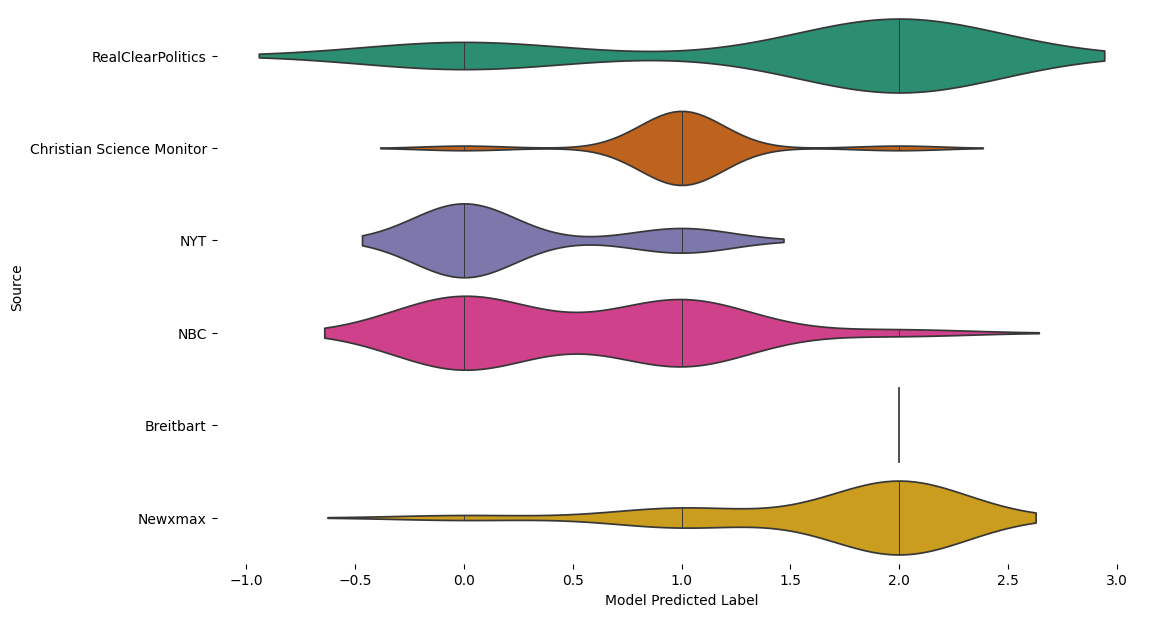

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(benchmark_df['Source'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(benchmark_df, x='Model Predicted Label', y='Source', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<ipython-input-32-36f5860cc745>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(benchmark_df, x='Model Predicted Label', y='Benchmark Label', inner='stick', palette='Dark2')


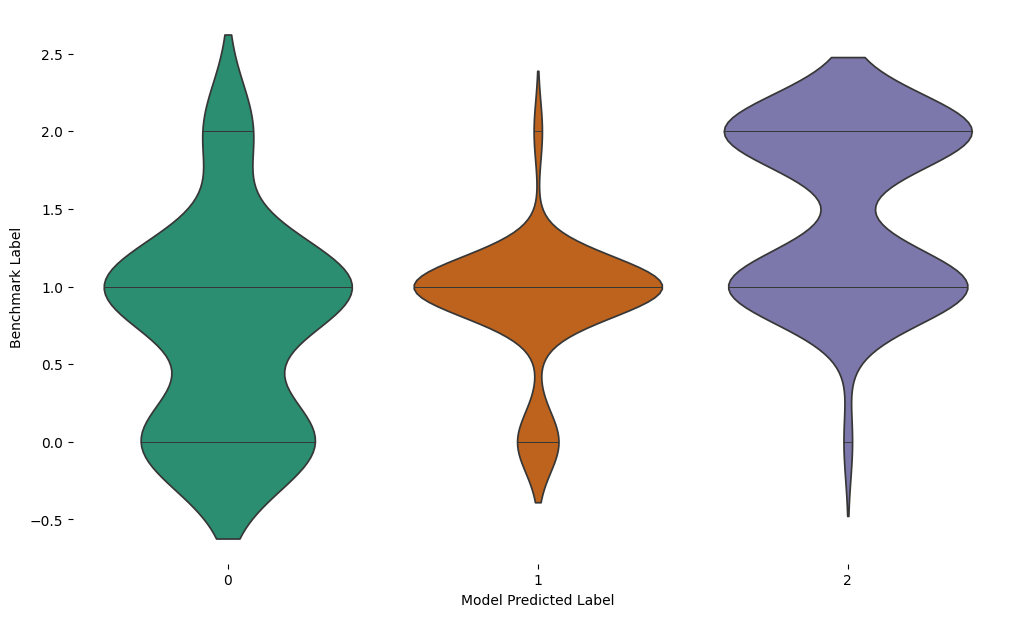

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(benchmark_df['Source'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(benchmark_df, x='Model Predicted Label', y='Benchmark Label', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

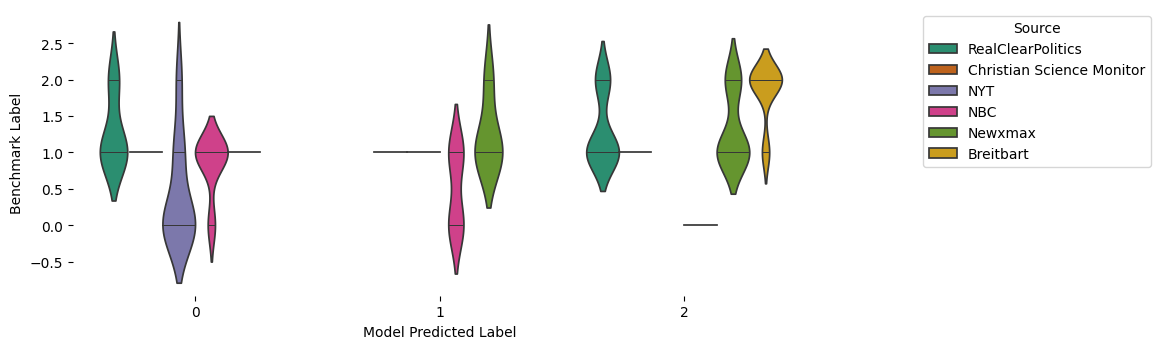

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns

figsize = (12, 1.2 * len(benchmark_df['Benchmark Label'].unique()))  # Adjust figsize if needed
plt.figure(figsize=figsize)

sns.violinplot(
    data=benchmark_df,
    x='Model Predicted Label',
    y='Benchmark Label',
    hue='Source',
    inner='stick',
    palette='Dark2',
)

# Move the legend further right
plt.legend(bbox_to_anchor=(1.15, 1), loc='upper left', title='Source')

sns.despine(top=True, right=True, bottom=True, left=True)
plt.tight_layout()  # Helps with spacing
plt.show()

In [ ]:
print(benchmark_df[benchmark_df['Source'] == 'Christian Science Monitor'])
print(benchmark_df[benchmark_df['Source'] == 'Christian Science Monitor']['Benchmark Label'].describe())

                       Source  \
26  Christian Science Monitor   
27  Christian Science Monitor   
28  Christian Science Monitor   
29  Christian Science Monitor   
30  Christian Science Monitor   
31  Christian Science Monitor   
32  Christian Science Monitor   
33  Christian Science Monitor   
34  Christian Science Monitor   
35  Christian Science Monitor   
36  Christian Science Monitor   
37  Christian Science Monitor   
38  Christian Science Monitor   
39  Christian Science Monitor   
40  Christian Science Monitor   
41  Christian Science Monitor   
42  Christian Science Monitor   
43  Christian Science Monitor   

                                                  URL General Bias Consensus  \
26  https://www.csmonitor.com/USA/Justice/2024/012...                 Center   
27  https://www.csmonitor.com/USA/Justice/2024/012...                 Center   
28  https://www.csmonitor.com/USA/Politics/2024/08...                 Center   
29  https://www.csmonitor.com/USA/Politics/2024/08..

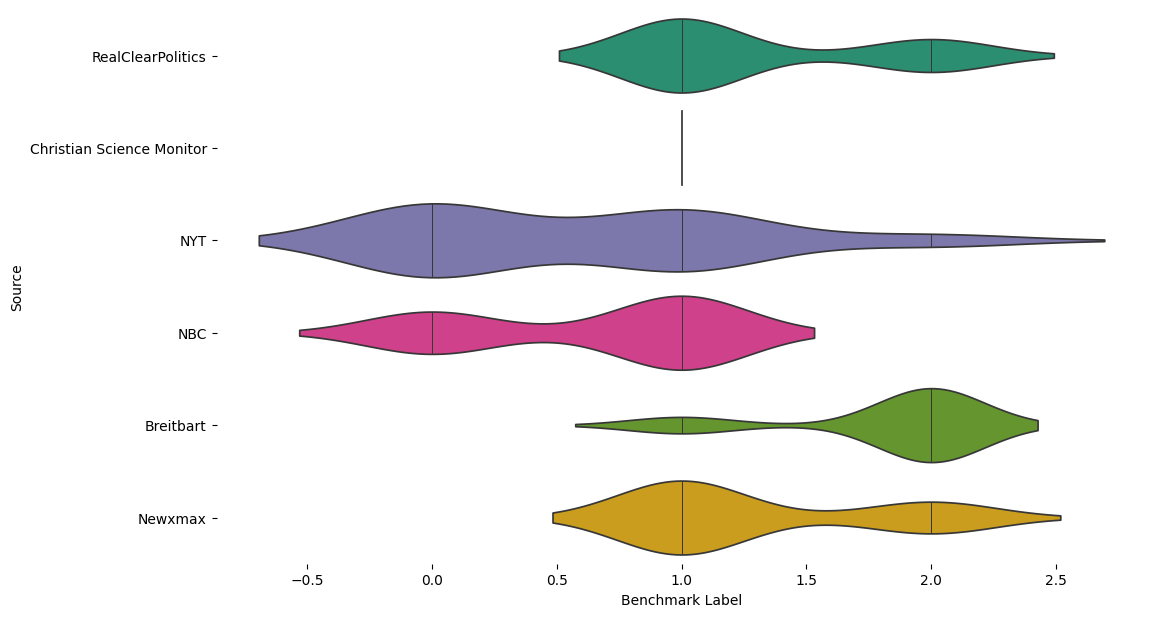

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(benchmark_df['Source'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(benchmark_df, x='Benchmark Label', y='Source', hue='Source', palette='Dark2', inner='stick')
sns.despine(top=True, right=True, bottom=True, left=True)

<ipython-input-36-74222c17667c>:15: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 1.88597091  1.00042088  1.1583088   0.84148549  0.43474224  0.01429227
  1.39155824  1.35546901  0.89640392  1.41063876 -0.11227952  1.24223578
  0.69729166  0.7135272   0.20061129  1.2924124   1.21398851  0.08865126]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  plot_df.loc[plot_df['Source'] == source, 'Benchmark Label'] += noise
<ipython-input-36-74222c17667c>:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(plot_df, x='Benchmark Label', y='Source', inner='stick', palette='Dark2')


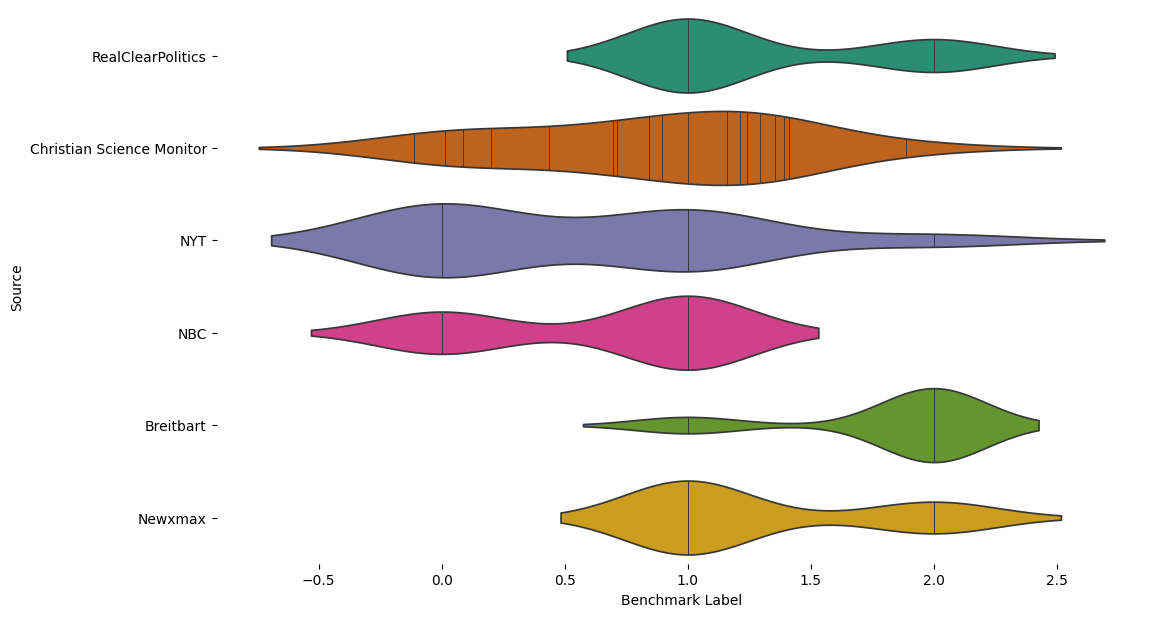

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np

# Create a copy of the DataFrame to avoid modifying the original data
plot_df = benchmark_df.copy()

# Identify sources with no variation (std = 0) in Benchmark Label
variation = plot_df.groupby('Source')['Benchmark Label'].std()
sources_no_variation = variation[variation == 0].index

# Add small random noise to Benchmark Label for sources with no variation
for source in sources_no_variation:
    noise = np.random.normal(0, 0.55, size=len(plot_df[plot_df['Source'] == source]))
    plot_df.loc[plot_df['Source'] == source, 'Benchmark Label'] += noise

# Plot the violin plot
figsize = (12, 1.2 * len(plot_df['Source'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(plot_df, x='Benchmark Label', y='Source', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)
plt.show()

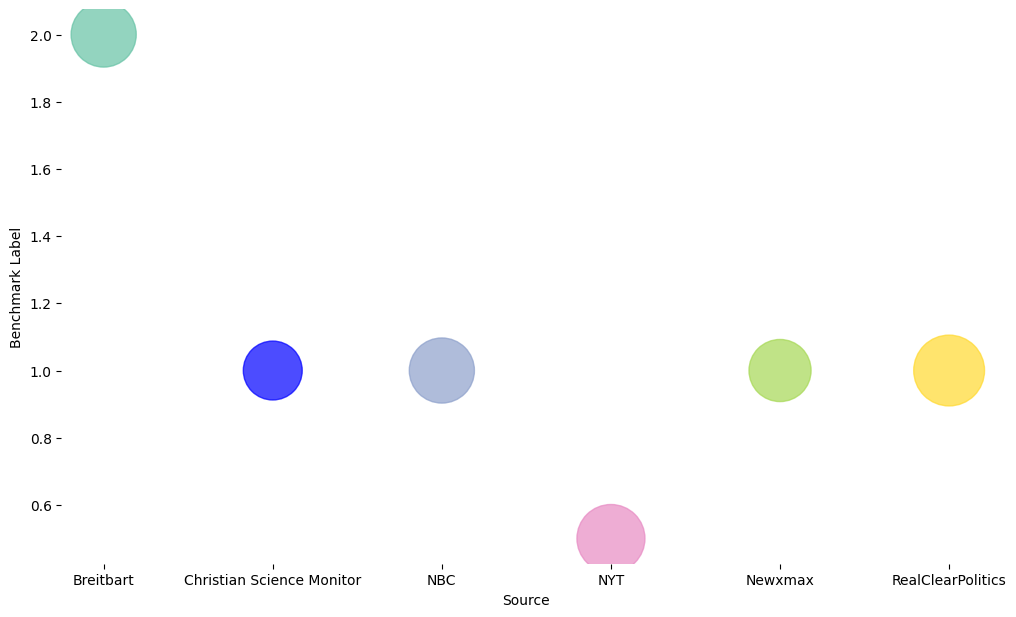

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd

# Aggregate the data: Calculate the median Benchmark Label and count of data points per source
agg_df = benchmark_df.groupby('Source').agg({
    'Benchmark Label': 'median',  # Median Benchmark Label for the x-axis
    'Source': 'count'  # Number of data points for bubble size
}).rename(columns={'Source': 'Count'}).reset_index()

# Plot the bubble chart
figsize = (12, 1.2 * len(agg_df['Source'].unique()))
plt.figure(figsize=figsize)

# Create a scatter plot where the size of each point (bubble) is proportional to the count
# Use the 'Set2' palette for colors
scatter = plt.scatter(
    x=agg_df['Source'],
    y=agg_df['Benchmark Label'],
    s=agg_df['Count'] * 100,  # Scale the count to make bubble sizes visible (adjust multiplier as needed)
    c=[sns.color_palette('Set2', len(agg_df['Source']))[i] if source != 'Christian Science Monitor' else 'blue'
       for i, source in enumerate(agg_df['Source'])],  # Set Christian Science Monitor to blue
    alpha=0.7  # Transparency for better visibility
)

# Customize the plot
plt.xlabel('Source')
plt.ylabel('Benchmark Label')
sns.despine(top=True, right=True, bottom=True, left=True)

# Show the plot
plt.show()

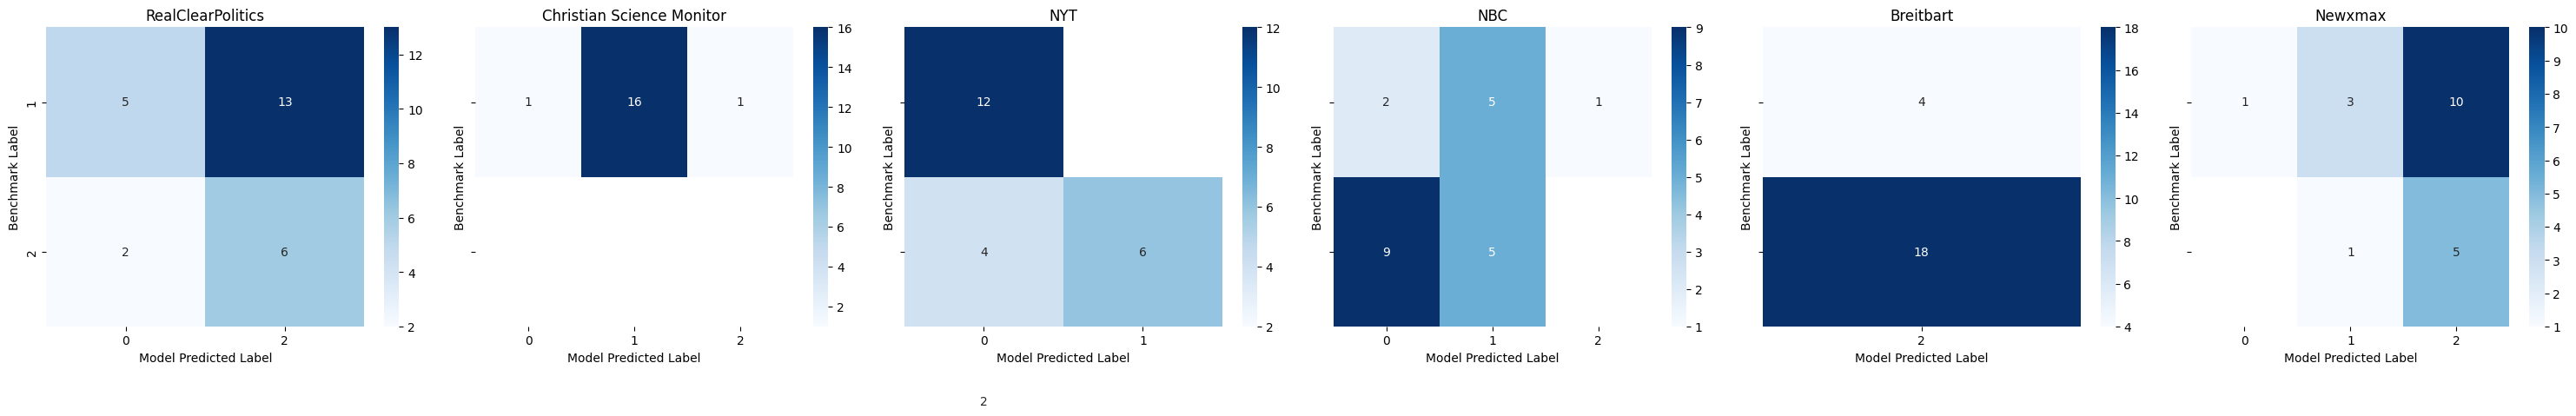

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Group and pivot the data
pivot_df = (
    benchmark_df
    .groupby(['Benchmark Label', 'Model Predicted Label', 'Source'])
    .size()
    .reset_index(name='count')
)

# Loop over each source and draw a heatmap
sources = benchmark_df['Source'].unique()
n_sources = len(sources)
fig, axes = plt.subplots(1, n_sources, figsize=(5 * n_sources, 5), sharey=True)

for i, source in enumerate(sources):
    data = pivot_df[pivot_df['Source'] == source].pivot(
        index='Benchmark Label', columns='Model Predicted Label', values='count'
    )
    sns.heatmap(data, annot=True, fmt='g', ax=axes[i], cmap='Blues')
    axes[i].set_title(source)

plt.tight_layout()
plt.show()

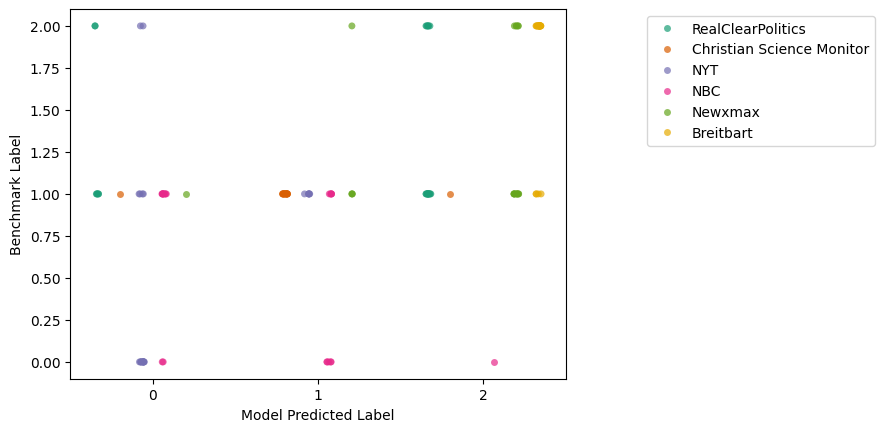

In [ ]:
sns.stripplot(
    data=benchmark_df,
    x='Model Predicted Label',
    y='Benchmark Label',
    hue='Source',
    dodge=True,
    jitter=True,
    palette='Dark2',
    alpha=0.7
)
plt.legend(bbox_to_anchor=(1.15, 1), loc='upper left')
plt.show()

In [ ]:
# Print accuracy report for logistic regression
logreg_df = benchmark_df[benchmark_df['Model'] == 'Logistic Regression'] # Changed the model name to match the benchmark file
print_accuracy_report(logreg_df['Benchmark Label'], logreg_df['Model Predicted Label'])

Accuracy: 0.545

              precision    recall  f1-score   support

           0       0.30      0.70      0.42        10
           1       0.84      0.41      0.55        39
           2       0.54      0.76      0.63        17

    accuracy                           0.55        66
   macro avg       0.56      0.62      0.54        66
weighted avg       0.68      0.55      0.55        66



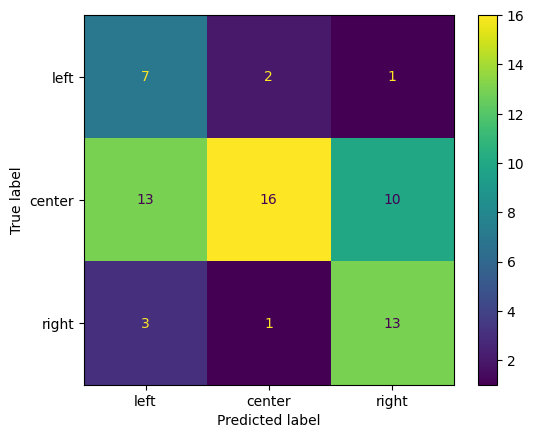

In [ ]:
# Confusion Matrix for logistc regression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


# Create a confusion matrix
cm = confusion_matrix(logreg_df['Benchmark Label'], logreg_df['Model Predicted Label'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['left', 'center', 'right'])
disp.plot()
plt.show()

In [ ]:
# Print accuracy report for SGDC classifier
sgdc_df = benchmark_df[benchmark_df['Model'] == 'SGDC Classifier']
print_accuracy_report(sgdc_df['Benchmark Label'], sgdc_df['Model Predicted Label'])

Accuracy: 0.561

              precision    recall  f1-score   support

           0       0.47      0.70      0.56        10
           1       0.82      0.36      0.50        39
           2       0.47      0.94      0.63        17

    accuracy                           0.56        66
   macro avg       0.59      0.67      0.56        66
weighted avg       0.68      0.56      0.54        66



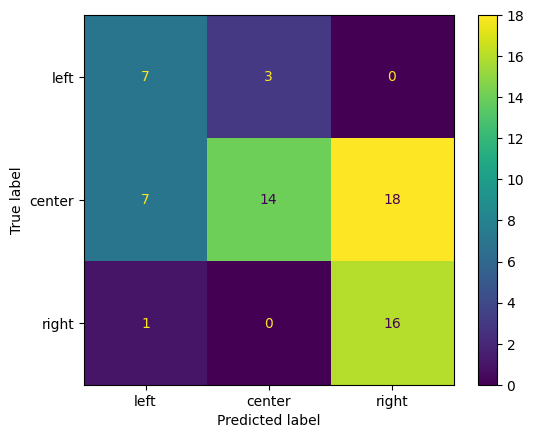

In [ ]:
# Confusion Matrix for logistc regression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


# Create a confusion matrix
cm = confusion_matrix(sgdc_df['Benchmark Label'], sgdc_df['Model Predicted Label'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['left', 'center', 'right'])
disp.plot()
plt.show()

In [ ]:
# Adjust the boundary of benchmark ratings of left, center, and right.
# Left: -6 to -1
# Center: -0.99 to 0.99
# Right: 1 to 6
# Add a new column called 'Benchmark Label Adjusted' where the value will be 0 if Allsides Rating is between -6 to -1, 1 if -0.99 to 0.99, and 2 if 1 to 6

def adjust_benchmark_label(x):
  if x >= -6 and x <= -1:
    return 0
  elif x >= -0.99 and x <= 0.99:
    return 1
  else:
    return 2

benchmark_df['Benchmark Label Adjusted'] = benchmark_df['All Sides Rating'].apply(adjust_benchmark_label)
benchmark_df.head()

,Source,URL,General Bias Consensus,Source Leaning,Model,Model Predicted Label,Benchmark Label,All Sides Rating,Topic,Benchmark Label Adjusted
0,RealClearPolitics,https://www.realclearpolitics.com/2024/03/26/h...,Center,1.5,Logistic Regression,0,1,-1.5,Candidates,0
1,RealClearPolitics,https://www.realclearpolitics.com/2024/03/26/h...,Center,1.5,SGDC Classifier,2,1,-1.5,Candidates,0
2,RealClearPolitics,https://www.realclearpolitics.com/video/2024/0...,Center,1.5,Logistic Regression,2,1,-1.5,Candidates,0
3,RealClearPolitics,https://www.realclearpolitics.com/video/2024/0...,Center,1.5,SGDC Classifier,2,1,-1.5,Candidates,0
4,RealClearPolitics,https://www.realclearpolitics.com/articles/202...,Center,1.5,Logistic Regression,0,1,0.5,Candidates,1


In [ ]:
# Print accuracy report for logistic regression again!!!!!!! >:)
logreg_df = benchmark_df[benchmark_df['Model'] == 'Logistic Regression']
print_accuracy_report(logreg_df['Benchmark Label Adjusted'], logreg_df['Model Predicted Label'])

Accuracy: 0.621

              precision    recall  f1-score   support

           0       0.48      0.55      0.51        20
           1       0.58      0.61      0.59        18
           2       0.79      0.68      0.73        28

    accuracy                           0.62        66
   macro avg       0.62      0.61      0.61        66
weighted avg       0.64      0.62      0.63        66



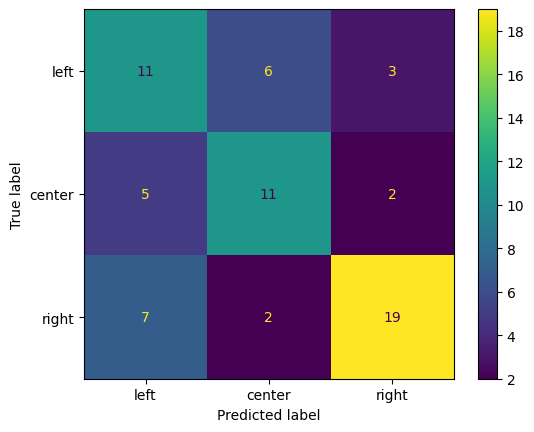

In [ ]:
# Confusion Matrix for logistc regression again!!!!!!! >:)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


# Create a confusion matrix
cm = confusion_matrix(logreg_df['Benchmark Label Adjusted'], logreg_df['Model Predicted Label'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['left', 'center', 'right'])
disp.plot()
plt.show()

In [ ]:
# Print accuracy report for SGDC classidier again!!!!!!!! >:)
sgdc_df = benchmark_df[benchmark_df['Model'] == 'SGDC Classifier']
print_accuracy_report(sgdc_df['Benchmark Label Adjusted'], sgdc_df['Model Predicted Label'])

Accuracy: 0.636

              precision    recall  f1-score   support

           0       0.60      0.45      0.51        20
           1       0.53      0.50      0.51        18
           2       0.71      0.86      0.77        28

    accuracy                           0.64        66
   macro avg       0.61      0.60      0.60        66
weighted avg       0.63      0.64      0.62        66



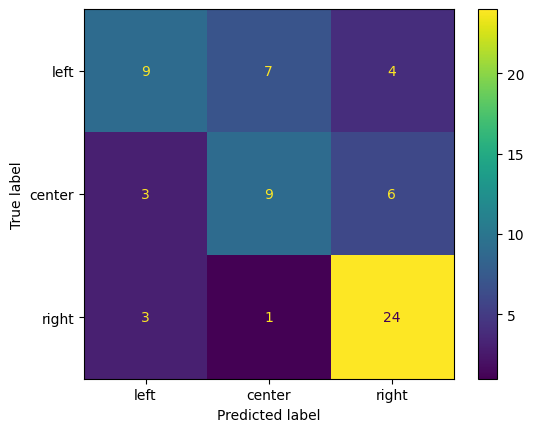

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


# Create a confusion matrix
cm = confusion_matrix(sgdc_df['Benchmark Label Adjusted'], sgdc_df['Model Predicted Label'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['left', 'center', 'right'])
disp.plot()
plt.show()

In [ ]:
# Calculate the average of Model Predicted Label for each source leaning
benchmark_df[['Source Leaning', 'Model Predicted Label']].groupby('Source Leaning').mean()

,Model Predicted Label
Source Leaning,
0.5,0.391304
1.0,1.000000
1.5,1.461538
2.0,1.857143


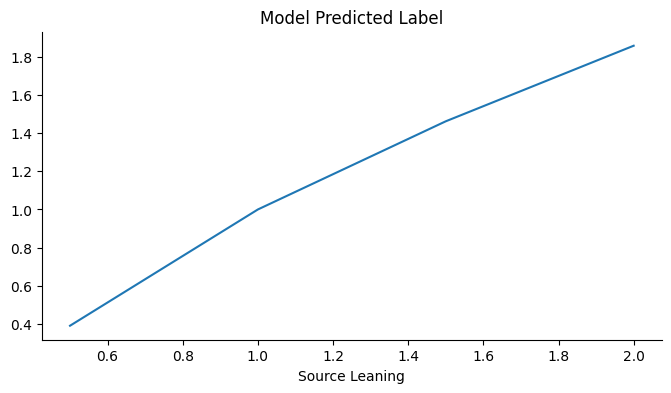

In [ ]:
# Plot the Average Sentence Bias Score against Source Leaning
temp_df = benchmark_df[['Source Leaning', 'Model Predicted Label']].groupby('Source Leaning').mean()
temp_df['Model Predicted Label'].plot(kind='line', figsize=(8, 4), title='Model Predicted Label')
plt.gca().spines[['top', 'right']].set_visible(False)

<ipython-input-53-c8ed35215b45>:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  topic_accuracy = benchmark_df.groupby('Topic').apply(lambda x: (x['Model Predicted Label'] == x['Benchmark Label']).mean()).reset_index(name='Accuracy')
<ipython-input-53-c8ed35215b45>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=topic_accuracy, x='Accuracy', y='Topic', palette='Blues_d')


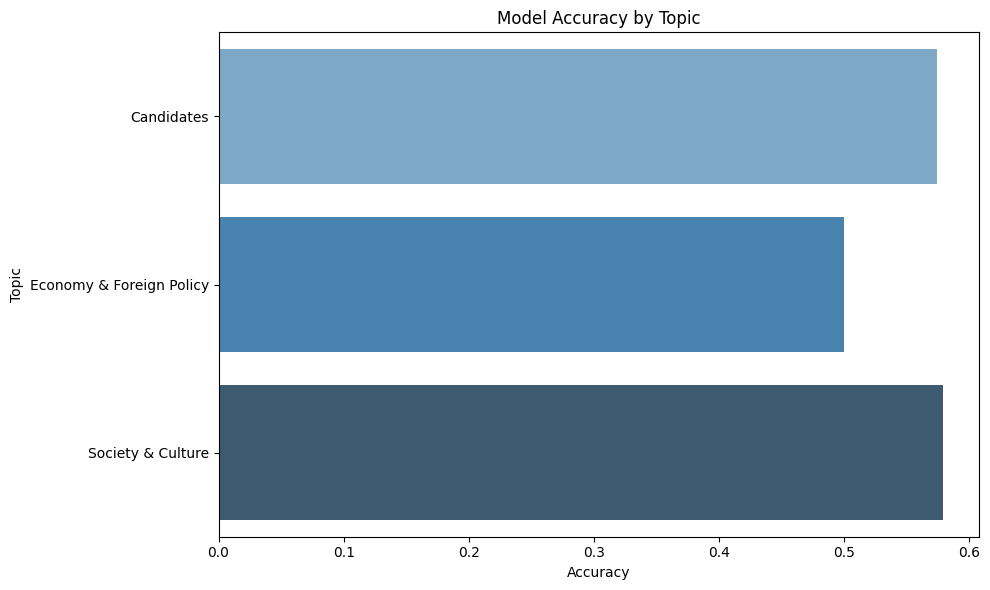

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate accuracy per topic
topic_accuracy = benchmark_df.groupby('Topic').apply(lambda x: (x['Model Predicted Label'] == x['Benchmark Label']).mean()).reset_index(name='Accuracy')

# Plot
plt.figure(figsize=(10,6))
sns.barplot(data=topic_accuracy, x='Accuracy', y='Topic', palette='Blues_d')
plt.title('Model Accuracy by Topic')
plt.xlabel('Accuracy')
plt.ylabel('Topic')
plt.tight_layout()
plt.show()

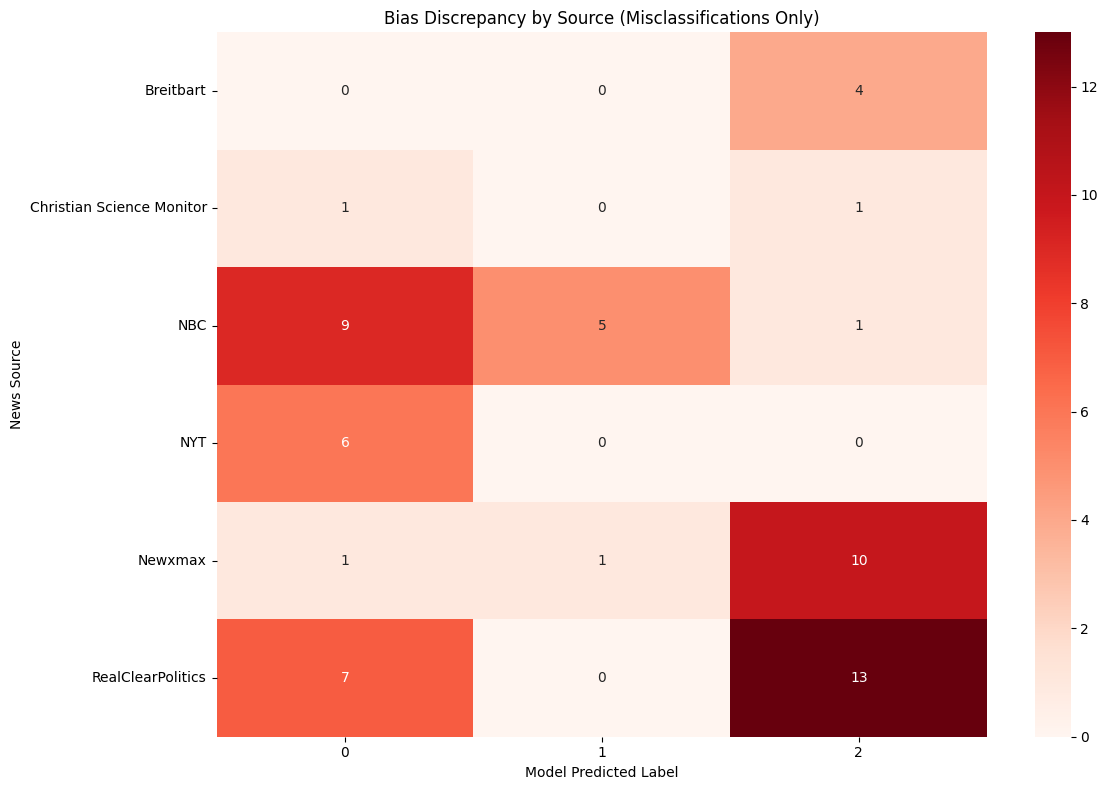

In [ ]:
# Create cross-tab of disagreement counts
heat_df = benchmark_df[benchmark_df['Model Predicted Label'] != benchmark_df['Benchmark Label']] # Changed df to benchmark_df
discrepancy_counts = pd.crosstab(heat_df['Source'], heat_df['Model Predicted Label'])

# Plot
plt.figure(figsize=(12,8))
sns.heatmap(discrepancy_counts, annot=True, cmap='Reds', fmt='d')
plt.title('Bias Discrepancy by Source (Misclassifications Only)')
plt.xlabel('Model Predicted Label')
plt.ylabel('News Source')
plt.tight_layout()
plt.show()

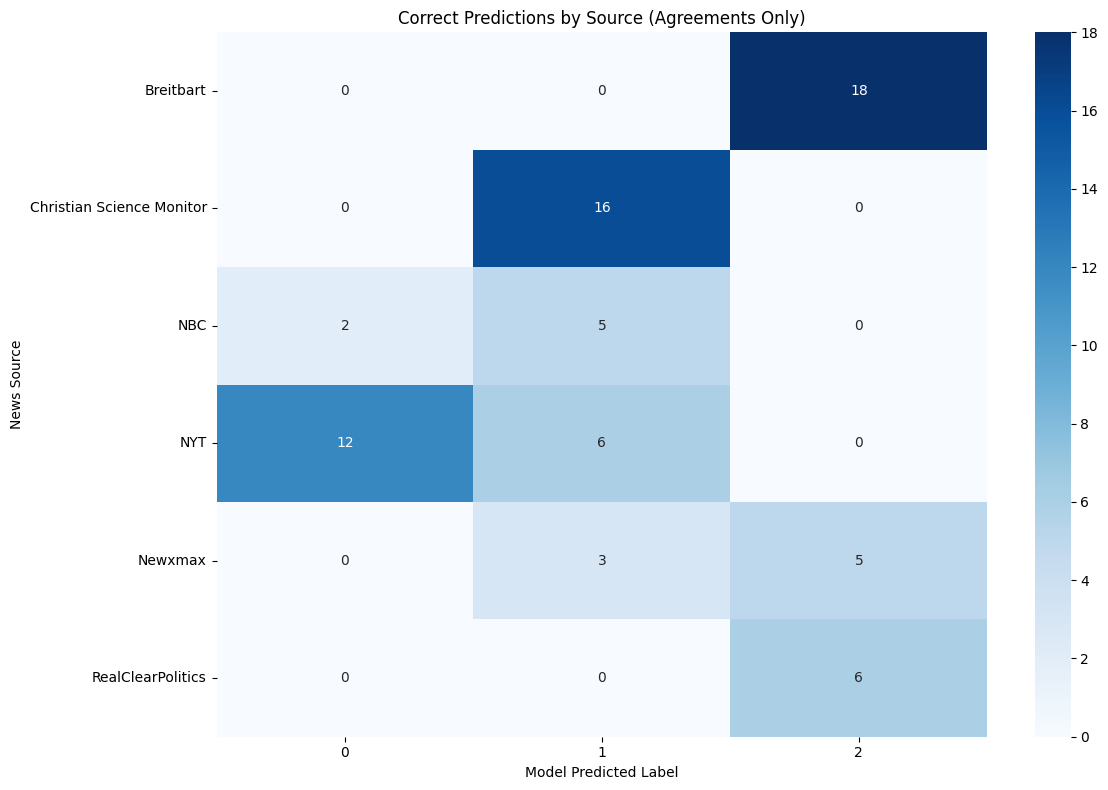

In [ ]:
# Create cross-tab of agreement counts
agree_df = benchmark_df[benchmark_df['Model Predicted Label'] == benchmark_df['Benchmark Label']]  # Filter where prediction matches benchmark
agreement_counts = pd.crosstab(agree_df['Source'], agree_df['Model Predicted Label'])  # Cross-tab of counts

# Plot
plt.figure(figsize=(12,8))
sns.heatmap(agreement_counts, annot=True, cmap='Blues', fmt='d')
plt.title('Correct Predictions by Source (Agreements Only)')
plt.xlabel('Model Predicted Label')
plt.ylabel('News Source')
plt.tight_layout()
plt.show()

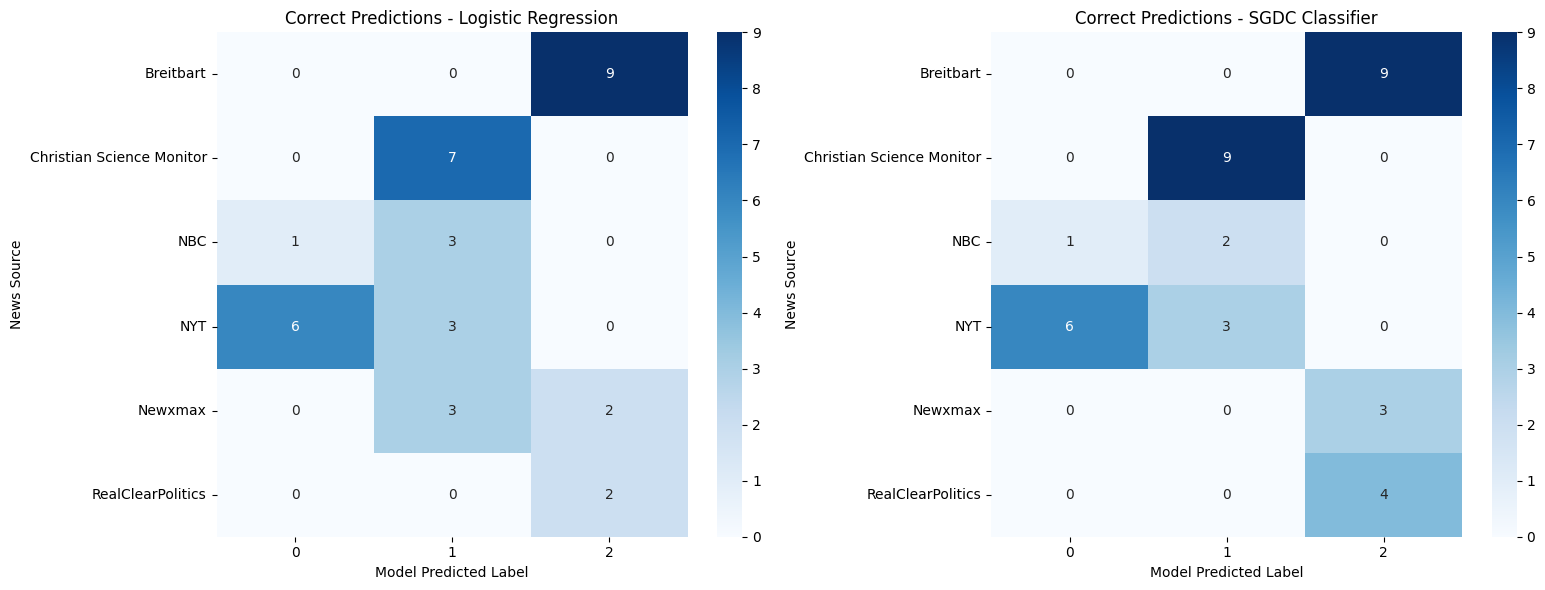

In [ ]:
# Get unique models
models = benchmark_df['Model'].unique()

# Set up subplot grid WITHOUT shared y-axis
fig, axes = plt.subplots(1, len(models), figsize=(16, 6), sharey=False)

# Loop through each model and create a heatmap on its subplot
for i, model in enumerate(models):
    model_df = benchmark_df[
        (benchmark_df['Model'] == model) &
        (benchmark_df['Model Predicted Label'] == benchmark_df['Benchmark Label'])
    ]
    model_agree_counts = pd.crosstab(model_df['Source'], model_df['Model Predicted Label'])

    sns.heatmap(model_agree_counts, annot=True, cmap='Blues', fmt='d', ax=axes[i])
    axes[i].set_title(f'Correct Predictions - {model}')
    axes[i].set_xlabel('Model Predicted Label')
    axes[i].set_ylabel('News Source')

    # Explicitly show y-tick labels on ALL subplots
    axes[i].set_yticklabels(model_agree_counts.index, rotation=0, fontsize=10)

# Add spacing between subplots
plt.subplots_adjust(wspace=0.4)
plt.tight_layout()
plt.show()

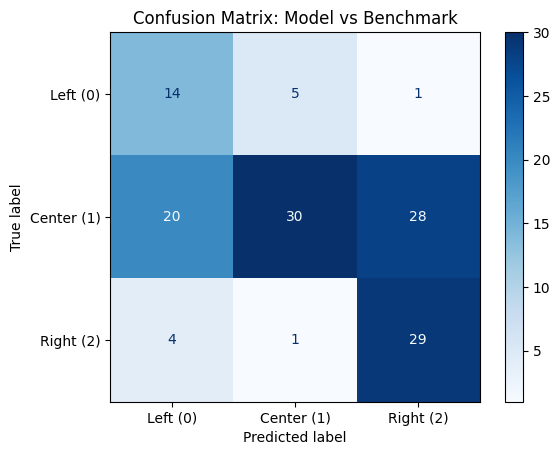

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(benchmark_df['Benchmark Label'], benchmark_df['Model Predicted Label'], labels=[0,1,2]) # Changed df to benchmark_df
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Left (0)', 'Center (1)', 'Right (2)'])

disp.plot(cmap='Blues')
plt.title('Confusion Matrix: Model vs Benchmark')
plt.show()

<ipython-input-59-e2153723b56e>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=benchmark_df, x='Model Predicted Label', y='All Sides Rating', palette='coolwarm') # Changed df to benchmark_df


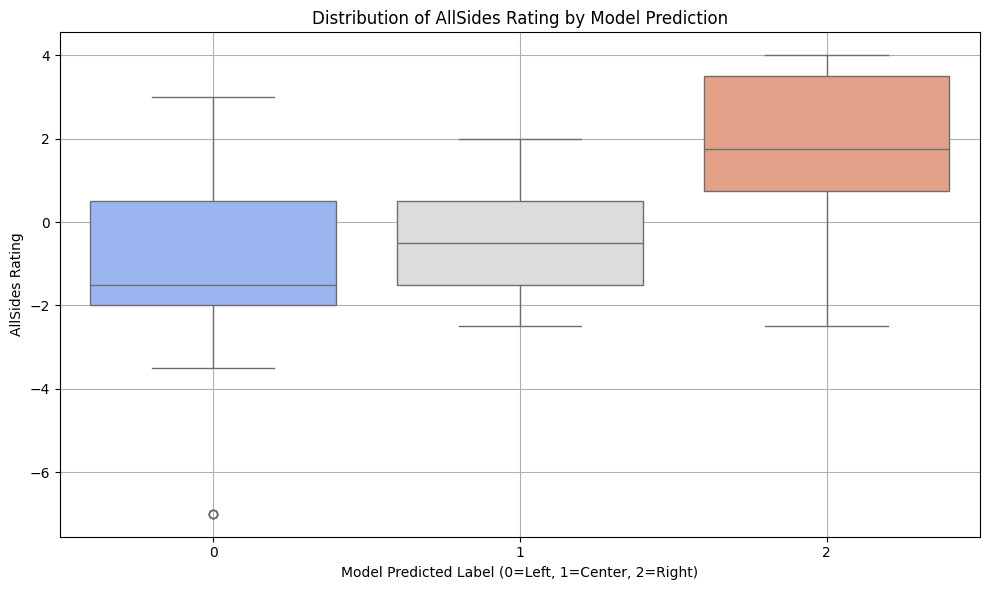

In [ ]:
plt.figure(figsize=(10,6))
sns.boxplot(data=benchmark_df, x='Model Predicted Label', y='All Sides Rating', palette='coolwarm') # Changed df to benchmark_df
plt.title('Distribution of AllSides Rating by Model Prediction')
plt.xlabel('Model Predicted Label (0=Left, 1=Center, 2=Right)')
plt.ylabel('AllSides Rating')
plt.grid(True)
plt.tight_layout()
plt.show()

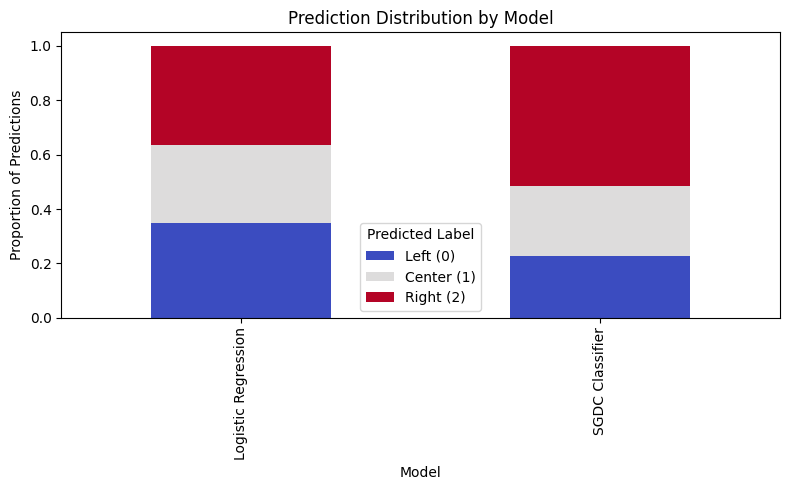

In [ ]:
# Count predictions by Model and Label
dist = benchmark_df.groupby(['Model', 'Model Predicted Label']).size().unstack().fillna(0) # Changed df to benchmark_df

# Normalize to percentages
dist_norm = dist.div(dist.sum(axis=1), axis=0)

# Plot
dist_norm.plot(kind='bar', stacked=True, colormap='coolwarm', figsize=(8,5))
plt.title('Prediction Distribution by Model')
plt.xlabel('Model')
plt.ylabel('Proportion of Predictions')
plt.legend(title='Predicted Label', labels=['Left (0)', 'Center (1)', 'Right (2)'])
plt.tight_layout()
plt.show()

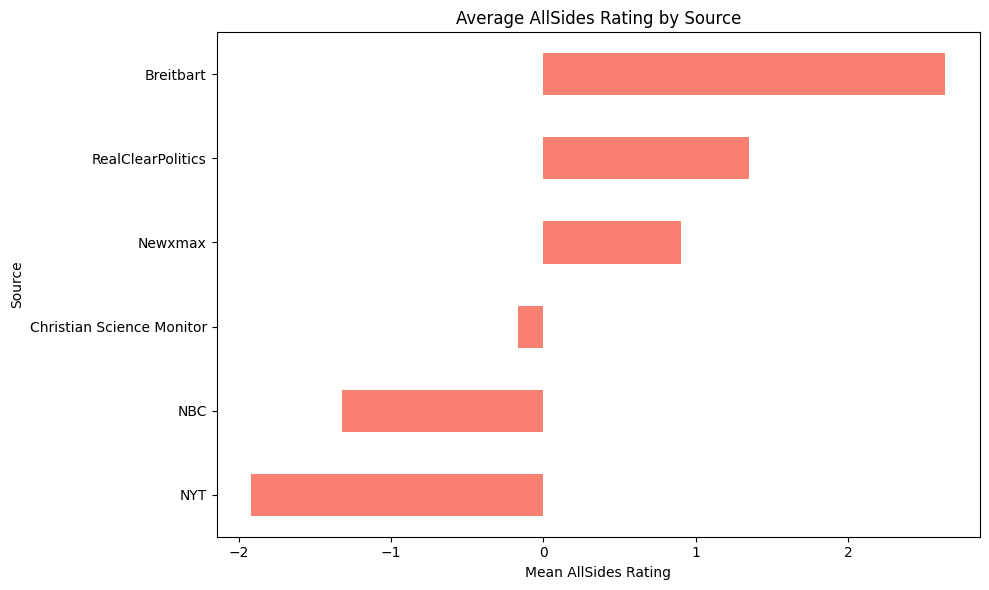

In [ ]:
source_bias = benchmark_df.groupby('Source')['All Sides Rating'].mean().sort_values()

plt.figure(figsize=(10,6))
source_bias.plot(kind='barh', color='salmon')
plt.title('Average AllSides Rating by Source')
plt.xlabel('Mean AllSides Rating')
plt.tight_layout()
plt.show()